In [1]:
import torch
import numpy as np
from tqdm import tqdm
from analytical_expressions import local_energy
from torch.autograd.functional import jacobian
from torch.func import jacrev
import matplotlib.pyplot as plt
from torch.func import vmap

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def psi(X):
    x = X[:3]
    y = X[3:6]
    alpha_1, alpha_2, alpha_3, alpha_4 = X[6:]
    r1 = torch.norm(x)
    r2 = torch.norm(y)
    r12 = torch.norm(x - y)

    term1 = torch.exp(-2 * (r1 + r2))
    term2 = 1 + 0.5 * r12 * torch.exp(-alpha_1 * r12)
    term3 = 1 + alpha_2 * (r1 + r2) * r12 + alpha_3 * (r1 - r2) ** 2 - alpha_4 * (r12) ** 2

    return term1 * term2 * term3

In [4]:
psi_vec = vmap(psi)

In [38]:
def metropolis(N: int, n_runs: int, alphas: torch.tensor):  
    """
    Vectorized metropolis loop
    Over N steps, for n_runs. 
    Alphas passes in must be of same dim as n_runs
    """  
    assert alphas.shape[0] == n_runs        
    L = 1
    r1 = (torch.rand(n_runs, 3) * 2 * L - L)
    r2 = (torch.rand(n_runs, 3) * 2 * L - L)
    max_steps = 500
    sampled_Xs = []
    rejection_ratio = 0

    for i in tqdm(range(N)):
        chose = torch.rand(n_runs).reshape(n_runs, 1)
        dummy = torch.rand(n_runs)

        perturbed_r1 = r1 + 0.5 * (torch.rand(n_runs, 3) * 2 * L - L)
        perturbed_r2 = r2 + 0.5 * (torch.rand(n_runs, 3) * 2 * L - L)

        r1_trial = torch.where(chose < 0.5, perturbed_r1, r1)
        r2_trial = torch.where(chose >= 0.5, perturbed_r2, r2)
        psi_val = psi_vec(torch.cat((r1, r2, alphas), axis=1))
        psi_trial_val = psi_vec(torch.cat((r1_trial, r2_trial, alphas), axis=1))      
        
        psi_ratio = (psi_trial_val / psi_val) ** 2

        #density_comp = psi_trial_val >= psi_val
        dummy_comp = dummy < psi_ratio

        condition = dummy_comp

        rejection_ratio += torch.where(condition, 1./N, 0.0)

        condition = condition.reshape(condition.shape[0], 1)

        # Careful with overwriting
        r1 = torch.where(condition, r1_trial, r1)
        r2 = torch.where(condition, r2_trial, r2)
                
        if i > max_steps:
            sampled_Xs.append(torch.cat((r1, r2, alphas), axis=1))

    #print(f"Rejection ratio is {torch.mean(rejection_ratio)}")

    return torch.stack(sampled_Xs)

In [6]:
local_e_vec = vmap(local_energy)
local_e_vec_vec = vmap(local_e_vec)

def get_local_energies(X):
    reshaped_X = X.reshape(
        X.shape[1], X.shape[0], X.shape[2])
    return local_e_vec_vec(reshaped_X)

def get_mean_energies(E):
    return torch.mean(torch.mean(E, dim=1))

In [7]:
def dE_dalpha(input):
    return jacrev(local_energy)(input)

dE_dalpha_vec = vmap(dE_dalpha)
dE_dalpha_vec_vec = vmap(dE_dalpha_vec)

def get_dE_dX(X):
    reshaped_X = X.reshape(
        X.shape[1], X.shape[0], X.shape[2])
    return dE_dalpha_vec_vec(X)

In [8]:
from gradient_expressions import get_psi_alpha

def get_gradients_from_expression(X_, E_):
    psi_alpha = vmap(get_psi_alpha)(X_)

    part_1 = psi_alpha - torch.mean(psi_alpha, axis=0)
    part_2 = E_ - torch.mean(E_)
    return torch.mean(part_1.T * part_2, axis=1)

dE_dalpha = vmap(get_gradients_from_expression)

In [9]:
alpha_1 = torch.tensor(1.013, dtype=torch.float64, requires_grad=True) # 1.013
alpha_2 = torch.tensor(0.2119, dtype=torch.float64, requires_grad=True)
alpha_3 = torch.tensor(0.1406, dtype=torch.float64, requires_grad=True)
alpha_4 = torch.tensor(0.003, dtype=torch.float64, requires_grad=True)

In [10]:
device = torch.device("cuda")
cpu = torch.device("cpu")

In [11]:
def running_average(tensor, window_size=None):
    cumsum = torch.cumsum(tensor, dim=0)
    if window_size is None:
        # For the full running average (over all elements)
        return cumsum / torch.arange(1, len(tensor) + 1, device=tensor.device, dtype=torch.float32)
    else:
        # For a moving average with a fixed window size
        window = torch.ones(window_size, device=tensor.device)
        conv = torch.conv1d(tensor.unsqueeze(0).unsqueeze(0), window.unsqueeze(0).unsqueeze(0), padding=window_size//2)
        return conv.squeeze(0).squeeze(0)

## Start of simulation

In [22]:
alpha_1 = torch.tensor(1.013, dtype=torch.float64) # 1.013
alpha_2 = torch.tensor(0.2119, dtype=torch.float64)
alpha_3 = torch.tensor(0.1406, dtype=torch.float64)
alpha_4 = torch.tensor(0.003, dtype=torch.float64)

In [35]:
alpha_1 = torch.tensor(0.8247160262340193, dtype=torch.float64, requires_grad=True) # 1.013
alpha_2 = torch.tensor(0.21146884222153542, dtype=torch.float64, requires_grad=True) # 1.013
alpha_3 = torch.tensor(0.13430521465096745, dtype=torch.float64, requires_grad=True) # 1.013
alpha_4 = torch.tensor(0.06794605861519858, dtype=torch.float64, requires_grad=True)

In [36]:
n_steps = 200
mc_steps = 5000
alphas = torch.tensor([alpha_1, alpha_2, alpha_3, alpha_4]).unsqueeze(0).repeat(n_steps, 1)
sampled_Xs = metropolis(mc_steps, n_steps, alphas=alphas)

100%|██████████| 5000/5000 [00:04<00:00, 1042.04it/s]


In [37]:
E = get_local_energies(sampled_Xs.to(device))
mean_E = get_mean_energies(E.to(cpu))
print(f"Mean energy is {torch.mean(torch.mean(E, axis=1))}")

Mean energy is -2.9205442453497152


In [29]:
reshaped_X = sampled_Xs.reshape(
        sampled_Xs.shape[1], sampled_Xs.shape[0], sampled_Xs.shape[2])

In [30]:
def get_energy(X):
    ke = -0.5  * torch.sum(torch.diag(torch.autograd.functional.hessian(psi, X))[:6]) / psi(X)
    r1 = X[:3]
    r2 = X[3:6]

    potential = -2 / torch.norm(r1) - 2 / torch.norm(r2) + 1 / torch.norm(r1 - r2)

    return (ke + potential)


In [ ]:
# Verifying local energy using Hessian
E_es = []

for i in tqdm(reshaped_X[0]):
    E_es.append(get_energy(i))

In [32]:
cumulative_average_energy = running_average(torch.mean(E.detach().cpu(), axis=0))

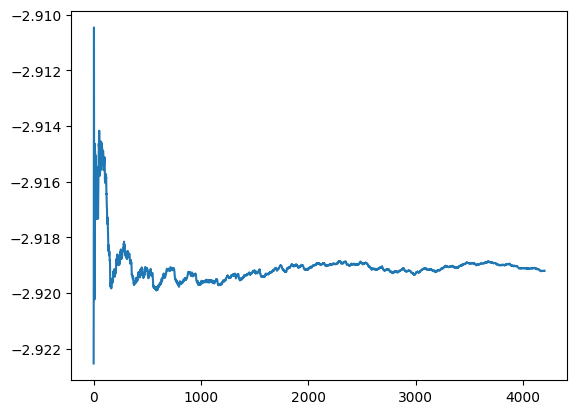

In [33]:
plt.plot(cumulative_average_energy)

In [129]:
def get_variances(E):
    # Variance in random walkers mean energy
    random_walker_variance = torch.mean((torch.mean(E.to(cpu), axis=1) - mean_E) ** 2)
    # Mean along the sample dimension (dim=1)
    mean_E_trial = E.mean(dim=1)                 # shape: (n_trials,)

    # Broadcasting: subtract column‑wise, then average again along dim=1
    var_E_trial  = torch.mean(((E - mean_E_trial[:, None]) ** 2).mean(dim=1))

    return random_walker_variance, var_E_trial

In [ ]:
get_variances(E.to(cpu))

(tensor(0.0001, dtype=torch.float64), tensor(0.1038, dtype=torch.float64))

In [243]:
E = E.to(cpu)

In [122]:
# Variance in random walkers mean energy
torch.mean((torch.mean(E.to(cpu), axis=1) - mean_E) ** 2)

tensor(0.0001, dtype=torch.float64)

In [123]:
mean_E_trial = torch.mean(E[0])

In [124]:
var_E_trial = torch.mean((E[0] - mean_E_trial) ** 2)

In [125]:
var_E_trial

tensor(0.0658, device='cuda:0', dtype=torch.float64)

In [199]:
gradients = get_dE_dX(sampled_Xs)

In [200]:
gradients.shape

torch.Size([197999, 10, 10])

In [ ]:
gradients[:,,0]

IndexError: too many indices for tensor of dimension 2

In [ ]:
gradients = dE_dalpha(reshaped_X, E)

In [204]:
gradients

tensor([[ 0.0200,  0.9286, -0.3509,  0.0442],
        [ 0.0192,  0.9276, -0.3715,  0.0441],
        [ 0.0197,  0.9357, -0.3774,  0.0445],
        [ 0.0202,  0.9328, -0.4052,  0.0444],
        [ 0.0185,  0.9524, -0.3745,  0.0402],
        [ 0.0193,  0.9448, -0.3588,  0.0458],
        [ 0.0196,  0.9282, -0.3814,  0.0436],
        [ 0.0191,  0.9400, -0.3920,  0.0426],
        [ 0.0193,  0.9328, -0.3661,  0.0448],
        [ 0.0194,  0.9308, -0.3764,  0.0435]], dtype=torch.float64)

In [202]:
reshaped_X = sampled_Xs.reshape(
        sampled_Xs.shape[1], sampled_Xs.shape[0], sampled_Xs.shape[2])

Energy value should be −2.901188

The actual value is −2.9037243770

## Optimization loop

In [27]:
import math

In [28]:
E_true = -2.9037243770

In [104]:
alpha_1 = torch.tensor(0.9827, dtype=torch.float64, requires_grad=True) # 1.013
alpha_2 = torch.tensor(0.2789, dtype=torch.float64, requires_grad=True) # 0.2119
alpha_3 = torch.tensor(0.2004, dtype=torch.float64, requires_grad=True) # 0.1406
alpha_4 = torch.tensor(0.0603, dtype=torch.float64, requires_grad=True) # 0.003

In [31]:
device = torch.device("cuda")
cpu = torch.device("cpu")

In [132]:
# Naive approach - define loss as true energy - found energy

epochs = 2000
alphas = [alpha_1, alpha_2, alpha_3, alpha_4]
losses = []
n_walkers = 50
met_steps = 10000
optimizer = torch.optim.Adam(alphas, lr=0.01)

for i in range(epochs):

    alphas_metropolis = torch.tensor(alphas).unsqueeze(0).repeat(n_walkers, 1)
    sampled_Xs = metropolis(met_steps, n_walkers, alphas=alphas_metropolis)

    with torch.no_grad():
        E = get_local_energies(sampled_Xs)
        mean_E = get_mean_energies(E)
        variances = get_variances(E.to(cpu))
        loss = torch.abs(E_true - mean_E)

        print(f"Mean energy is {mean_E}\n"
              f"Loss is {loss}\n"
              f"Random walker variance {variances[0]}\n"
              f"Local energy variance {variances[1]}"
        )

        losses.append(loss.item())

        reshaped_X = sampled_Xs.reshape(
            sampled_Xs.shape[1], sampled_Xs.shape[0], sampled_Xs.shape[2])
        gradients = dE_dalpha(reshaped_X, E).to(cpu)

        # Now, assume you already have gradients computed externally:
        # Example: for step t, these are your gradients (replace with actual values)
        gradients = torch.mean(gradients, axis=0)
        external_grads = gradients.detach()

        # Step 3: Assign gradients manually
        for p, g in zip(alphas, external_grads):
            p.grad = g  # assign your externally computed gradient

    # Step 4: Optimizer step
    optimizer.step()
    optimizer.zero_grad()

    torch.cuda.empty_cache()
    del sampled_Xs
    del reshaped_X
    del E




100%|██████████| 10000/10000 [00:08<00:00, 1150.48it/s]


Mean energy is -2.9178804916696506
Loss is 0.0141561146696505
Random walker variance 7.169301774396275e-05
Local energy variance 0.07956617028801743


100%|██████████| 10000/10000 [00:09<00:00, 1076.44it/s]


Mean energy is -2.9200371430293512
Loss is 0.016312766029351167
Random walker variance 4.7193750729790704e-05
Local energy variance 0.0758153340668473


100%|██████████| 10000/10000 [00:08<00:00, 1148.82it/s]


Mean energy is -2.922872203243502
Loss is 0.019147826243501864
Random walker variance 0.00011955387653036473
Local energy variance 0.08970157499625078


100%|██████████| 10000/10000 [00:09<00:00, 1082.30it/s]


Mean energy is -2.9242166995757883
Loss is 0.020492322575788258
Random walker variance 9.235066447286049e-05
Local energy variance 0.07287558266555759


100%|██████████| 10000/10000 [00:08<00:00, 1114.15it/s]


Mean energy is -2.9232741698581424
Loss is 0.01954979285814229
Random walker variance 5.7820295290702506e-05
Local energy variance 0.0743656816383172


100%|██████████| 10000/10000 [00:09<00:00, 1089.12it/s]


Mean energy is -2.9220396952081815
Loss is 0.01831531820818144
Random walker variance 7.137714090678459e-05
Local energy variance 0.08438945120833763


100%|██████████| 10000/10000 [00:09<00:00, 1098.56it/s]


Mean energy is -2.917323836495966
Loss is 0.01359945949596586
Random walker variance 0.0001329973558224557
Local energy variance 0.09750426326797496


100%|██████████| 10000/10000 [00:09<00:00, 1097.94it/s]


Mean energy is -2.9191622701546756
Loss is 0.015437893154675475
Random walker variance 6.654526531666406e-05
Local energy variance 0.08682313973742575


100%|██████████| 10000/10000 [00:09<00:00, 1044.20it/s]


Mean energy is -2.92222985085961
Loss is 0.01850547385960999
Random walker variance 5.1106023494927e-05
Local energy variance 0.08109748184248311


100%|██████████| 10000/10000 [00:09<00:00, 1093.72it/s]


Mean energy is -2.9194536914022167
Loss is 0.015729314402216588
Random walker variance 6.354041617456202e-05
Local energy variance 0.0760671766810205


100%|██████████| 10000/10000 [00:09<00:00, 1076.18it/s]


Mean energy is -2.9233969269517717
Loss is 0.01967254995177159
Random walker variance 6.356949169456245e-05
Local energy variance 0.07611599429111938


100%|██████████| 10000/10000 [00:08<00:00, 1112.14it/s]


Mean energy is -2.9247556348493005
Loss is 0.021031257849300378
Random walker variance 0.00012393143169213877
Local energy variance 0.09374420441990317


 33%|███▎      | 3349/10000 [00:03<00:06, 1047.45it/s]


KeyboardInterrupt: 

In [102]:
alphas

[tensor(0.9827, dtype=torch.float64, requires_grad=True),
 tensor(0.2789, dtype=torch.float64, requires_grad=True),
 tensor(0.2004, dtype=torch.float64, requires_grad=True),
 tensor(0.0603, dtype=torch.float64, requires_grad=True)]

In [93]:
alphas

[tensor(0.1809, dtype=torch.float64),
 tensor(0.7604, dtype=torch.float64),
 tensor(0.4517, dtype=torch.float64),
 tensor(0.6952, dtype=torch.float64)]

In [41]:
print(alphas)

[tensor(1.0066, dtype=torch.float64), tensor(0.2158, dtype=torch.float64), tensor(0.1529, dtype=torch.float64), tensor(0.0154, dtype=torch.float64)]


In [26]:
print(gradients)

tensor([-0.0752,  3.5492, -0.0362, -0.6221], dtype=torch.float64,
       grad_fn=<MeanBackward1>)


In [27]:
print(alphas)

[tensor(0.5331, dtype=torch.float64, requires_grad=True), tensor(-0.0537, dtype=torch.float64, requires_grad=True), tensor(0.7332, dtype=torch.float64, requires_grad=True), tensor(-0.0505, dtype=torch.float64, requires_grad=True)]


In [137]:
alpha_1 = torch.tensor(2.013, dtype=torch.float64, requires_grad=True) # 1.013
alpha_2 = torch.tensor(0.6419, dtype=torch.float64, requires_grad=True) # 0.2119
alpha_3 = torch.tensor(2.1406, dtype=torch.float64, requires_grad=True) # 0.1406
alpha_4 = torch.tensor(3.003, dtype=torch.float64, requires_grad=True) # 0.003

In [113]:
alpha_1

tensor(2.0130, dtype=torch.float64, requires_grad=True)

In [106]:
external_grads

tensor([-0.0080,  0.0429,  0.0155, -0.0305], dtype=torch.float64)

## Gradient values

In [34]:
def dE_dalpha(input):
    return jacrev(local_energy)(input)

t = dE_dalpha_vec(torch.stack(inputs_arr[0]))

In [72]:
dE_dalpha_mean = torch.mean(t, axis=0)

In [36]:
psi_vmap = vmap(psi)

In [38]:
psi_values = psi_vmap(torch.stack(inputs_arr[0]))

In [61]:
mean_energy = sum(energies[0])/(len(energies[0]))

In [63]:
El_Etheta = energies[0] - mean_energy

In [65]:
mean_psi = torch.mean(psi_values)

In [73]:
dE_dalpha_mean.shape

torch.Size([10])

In [86]:
t[0].shape

torch.Size([10])

In [89]:
psi_values.shape

torch.Size([9500])

In [92]:
psi_dalph = torch.stack([psi_values[i] * t[i] for i in range(len(t))])

In [97]:
psi_dalph.shape

torch.Size([9500, 10])

In [98]:
dE_dalpha_mean.shape

torch.Size([10])

In [95]:
mean_psi

tensor(0.0207, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [77]:
t.shape

torch.Size([9500, 10])

In [111]:
a = psi_values.unsqueeze(1).repeat(1, 10) * t

In [110]:
b = (mean_psi * dE_dalpha_mean).unsqueeze(0).repeat(9500, 1)

In [119]:
c = (energies[0] - mean_energy).unsqueeze(1).repeat(1, 10)

In [115]:
mean_energy.shape

torch.Size([])

In [120]:
gradients = (a - b) * (c)

In [124]:
torch.mean(gradients, axis=0)

tensor([ 0.0652,  0.4838,  0.4329,  0.0146,  0.1017,  0.0883,  0.0167, -0.0222,
        -0.0307,  0.0271], dtype=torch.float64, grad_fn=<MeanBackward1>)

In [52]:
energies[0][1]

tensor(-1.6312, dtype=torch.float64, grad_fn=<SelectBackward0>)

In [53]:
E_fixed = [energies[0][i] / psi_values[i] for i in range(len(inputs_arr[0]))]

In [55]:
torch.mean(torch.stack(E_fixed))

tensor(-2546.7772, dtype=torch.float64, grad_fn=<MeanBackward0>)